In [1]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import math
from math import exp, pi,sin,cos

np.random.seed(1)
tf.set_random_seed(1)
###########设置定义域范围

a = 0
b = 1
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, layers_U, layers_V1,layers_V2,layers_V3, layers_V4,layers_F, x_range, f, num_train_tps):

        # Initialize NNs
        self.layers_U = layers_U
        self.weights_U, self.biases_U, self.adaps_U = self.initialize_NN(layers_U)
        self.layers_V1 = layers_V1
        self.weights_V1, self.biases_V1, self.adaps_V1 = self.initialize_NN(layers_V1)
        self.layers_V2 = layers_V2
        self.weights_V2, self.biases_V2, self.adaps_V2 = self.initialize_NN(layers_V2)
        self.layers_V3 = layers_V3
        self.weights_V3, self.biases_V3, self.adaps_V3 = self.initialize_NN(layers_V3)
        self.layers_V4 = layers_V4
        self.weights_V4, self.biases_V4, self.adaps_V4 = self.initialize_NN(layers_V4)
        self.layers_F = layers_F
        self.weights_F, self.biases_F, self.adaps_F = self.initialize_NN(layers_F)

        # Parameters
        self.x_range =x_range
        self.lb = np.array([ x_range[0]])
        self.ub = np.array([ x_range[1]])
        # Output file
        self.f = f
        self.xx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.ux_star_tf = tf.placeholder(tf.float32, shape=[None, 1])
        # Test Points                           ######################测试点
        self.x_test_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # Generate Training and Testing Points  ########################生成训练和测试点
        self.generateTrain(num_train_tps)

        # Physics
        self.f, self.e1, self.e2, self.e3,self.e4, self.Ux, self.V1x, self.V2x, self.V3x,self.V4x, self.U_xx, self.V1_xx, self.V2_xx, self.V3_xx,self.V4_xx, self.V1ex, self.V2ex, self.V3ex, self.V4ex, self.Fx, self.F_xx = self.pinn(
            self.xx_tf)
        self.f, self.e1,self.e2,self.e3,self.e4, self.Uf, self.V1f,self.V2f,self.V3f,self.V4f,self.U_xf,self.V1_xf,self.V2_xf,self.V3_xf,self.V4_xf,self.V1e,self.V2e,self.V3e,self.V4e,self.Ff, self.F_xf= self.pinn(self.xf)
        _,_,_,_,_,self.Ui, self.V1i,self.V2i,self.V3i,self.V4i,_,_,_,_,_,_,_,_,_,_,_,= self.pinn(self.xi)
        _,_,_,_,_,_,_,_,_,_,_,_,_,_,_,self.V1e,self.V2e,self.V3e,self.V4e,_,_= self.pinn(self.xe)
        self.f_test,  self.e1_test, self.e2_test,self.e3_test,self.e4_test,self.U_test, self.V1_test,self.V2_test,self.V3_test,self.V4_test,self.U_x_test,self.V1_x_test,self.V2_x_test,self.V3_x_test,self.V4_x_test,_,_,_,_,self.F_test,self.F_xtest= self.pinn(self.x_test_tf)

        self.loss_U = tf.reduce_mean((self.Ux - self.ux_star_tf) ** 2)
        self.loss_F = tf.reduce_mean((self.Ff - 2*tf.exp(2*self.xf)-1.0+tf.exp(self.xf**2+2*self.xf)) ** 2)
        self.loss_f = tf.reduce_mean(((self.xf+2)*(self.V1f+self.xf*self.V2f+0.5*self.xf**2*self.V3f+self.xf**3*self.V4f/6)+self.Ff-self.U_xf)** 2)
        self.loss_e1 = tf.reduce_mean((self.V1_xf -self.Uf)** 2)
        self.loss_e2 = tf.reduce_mean((self.V2_xf - self.xf*self.Uf) ** 2)
        self.loss_e3 = tf.reduce_mean((self.V3_xf -self.xf**2*self.Uf) ** 2)
        self.loss_e4 = tf.reduce_mean((self.V4_xf - self.xf ** 3 * self.Uf) ** 2)
        self.loss_i= tf.reduce_mean((self.Ui-1) ** 2)+tf.reduce_mean((self.V1i) ** 2)\
                     +tf.reduce_mean((self.V2i) ** 2)+tf.reduce_mean((self.V3i) ** 2)+tf.reduce_mean((self.V4i) ** 2)


        # # Total Loss
        self.loss =self.loss_U*10+self.loss_F+self.loss_f *1+ self.loss_e1*1+ self.loss_e2*1+self.loss_e3*1+ self.loss_e4*1+self.loss_i*1


        # Optimizer
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)

#####################初始化神经网络参数
    def initialize_NN(self, layers):
        weights = []
        biases = []
        adaps = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            a = tf.Variable(1.0, dtype=tf.float32)
            weights.append(W)
            biases.append(b)
            adaps.append(a)
        return weights, biases, adaps

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def net_U(self, X):
        weights = self.weights_U
        biases = self.biases_U
        adaps = self.adaps_U
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        U = tf.add(tf.matmul(h, W), b)
        return U

    def net_V1(self, X):
        weights = self.weights_V1
        biases = self.biases_V1
        adaps = self.adaps_V1
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V1 = tf.add(tf.matmul(h, W), b)
        return V1
    def net_V2(self, X):
        weights = self.weights_V2
        biases = self.biases_V2
        adaps = self.adaps_V2
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V2= tf.add(tf.matmul(h, W), b)
        return V2
    def net_V3(self, X):
        weights = self.weights_V3
        biases = self.biases_V3
        adaps = self.adaps_V3
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V3 = tf.add(tf.matmul(h, W), b)
        return V3
    def net_V4(self, X):
        weights = self.weights_V4
        biases = self.biases_V4
        adaps = self.adaps_V4
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        V4 = tf.add(tf.matmul(h, W), b)
        return V4

    def net_F(self, X):
        weights = self.weights_F
        biases = self.biases_F
        adaps = self.adaps_F
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        F = tf.add(tf.matmul(h, W), b)
        return F
    #
    def pinn(self,x):
        X=x
        # x=self.x_range[1] * tf.ones(x.shape)
        U = self.net_U(X)
        V1 =self.net_V1(X)
        V2 =self.net_V2(X)
        V3= self.net_V3(X)
        V4 = self.net_V4(X)
        V1e = self.net_V1(X)
        V2e= self.net_V2(X)
        V3e = self.net_V3(X)
        V4e = self.net_V4(X)
        F = self.net_F(X)


        U_x = tf.gradients(U, x)  # du/dx
        V1_x = tf.gradients(V1, x)  # dv1/dx
        V2_x = tf.gradients(V2, x)  # dv2dx
        V3_x = tf.gradients(V3, x)  # dv3/dx
        V4_x = tf.gradients(V4, x)
        F_x = tf.gradients(F, x)  # dLM/dx

        f =F+(x+2)*(V1+x*V2+0.5*x**2*V3+x**3*V4/6)-U_x
        e1 =V1_x-U
        e2 = V2_x-x*U
        e3 =V3_x -x**2* U
        e4 = V4_x - x ** 3 * U


        return f,e1,e2,e3,e4,U,V1,V2,V3,V4, U_x ,V1_x,V2_x,V3_x,V4_x,V1e,V2e,V3e,V4e, F, F_x


    def generateTrain(self, num_train_tps):
        xf = tf.linspace(np.float32(self.x_range[0]), np.float32(self.x_range[1]), 200)
        self.xf = tf.reshape(xf, [-1, 1])
        xi = self.x_range[0] * tf.ones(xf.shape)
        self.xi = tf.reshape(xi, [-1, 1])
        xe = self.x_range[1] * tf.ones(xf.shape)
        self.xe = tf.reshape(xe, [-1, 1])
        return

    def train(self, Xx,Ux, it, printloss):
        xx=Xx[:,0:1]
        xx = np.reshape(xx, [-1, 1])
        ux=Ux[:,0:1]
        ux = ux.reshape(-1, 1)

        tf_dict = {self.xx_tf: xx,self.ux_star_tf: ux}


        self.sess.run(self.train_op_Adam, tf_dict)

        loss_value, loss_value_U,loss_value_F,loss_value_f,loss_value_e1,loss_value_e2,loss_value_e3,loss_value_e4,loss_value_i= self.sess.run(
            [self.loss, self.loss_U,self.loss_F,self.loss_f,self.loss_e1,self.loss_e2,self.loss_e3,self.loss_e4,self.loss_i
             ], tf_dict)
        loss_value_array = [loss_value_U*10,loss_value_F*1,loss_value_f*1,loss_value_e1*1,loss_value_e2*1,loss_value_e3*1,loss_value_e4*1,loss_value_i*1]
        np.set_printoptions(precision=6)
        content = it, loss_value
        print(content, flush=True)
        # self.f.write(content + "\n")
        return loss_value, loss_value_array

    def test(self, num_test_tps):
        x = np.linspace(self.x_range[0], self.x_range[1], num_test_tps)
        x_test = np.reshape(x, [-1, 1])
        tf_dict = {self.x_test_tf: x_test}
        U_test = self.sess.run(self.U_test, tf_dict)
        V1_test = self.sess.run(self.V1_test, tf_dict)
        V2_test = self.sess.run(self.V2_test, tf_dict)
        V3_test = self.sess.run(self.V3_test, tf_dict)
        V4_test = self.sess.run(self.V4_test, tf_dict)
        F_test = self.sess.run(self.F_test, tf_dict)
        U_test_x = tf.gradients(U_test, x_test)
        V1_test_x = tf.gradients(V1_test, x_test)
        V2_test_x = tf.gradients(V2_test, x_test)
        V3_test_x = tf.gradients(V3_test, x_test)
        V4_test_x = tf.gradients(V4_test, x_test)
        f_test = self.sess.run(self.f_test, tf_dict)
        e1_test = self.sess.run(self.e1_test, tf_dict)
        e2_test = self.sess.run(self.e2_test, tf_dict)
        e3_test = self.sess.run(self.e3_test, tf_dict)
        e4_test = self.sess.run(self.e4_test, tf_dict)
        return x_test, U_test, V1_test, V2_test,V3_test,V4_test,f_test,e1_test,e2_test,e3_test,e4_test,U_test_x,V1_test_x,V2_test_x,V3_test_x,V4_test_x,F_test
def import_data(filepath):

    data =np.loadtxt("UF.txt", delimiter=None, converters=None, skiprows=0, usecols=None, unpack=False, ndmin=0)
    Xx = data[:, 0:1]
    Ux = data[:,1:2]
    return Xx, Ux



(1, 164.42119)
(2, 161.8913)
(3, 159.41531)
(4, 156.94923)
(5, 154.50026)
(6, 152.07751)
(7, 149.6792)
(8, 147.29132)
(9, 144.89258)
(10, 142.46286)
(11, 139.98985)
(12, 137.46881)
(13, 134.89993)
(14, 132.28467)
(15, 129.62392)
(16, 126.91802)
(17, 124.16831)
(18, 121.378204)
(19, 118.553505)
(20, 115.70118)
(21, 112.82848)
(22, 109.941635)
(23, 107.04564)
(24, 104.14484)
(25, 101.24408)
(26, 98.34943)
(27, 95.468185)
(28, 92.60777)
(29, 89.77469)
(30, 86.97401)
(31, 84.209496)
(32, 81.48397)
(33, 78.799355)
(34, 76.15606)
(35, 73.55264)
(36, 70.9857)
(37, 68.4509)
(38, 65.94372)
(39, 63.46041)
(40, 60.998104)
(41, 58.554928)
(42, 56.130306)
(43, 53.725502)
(44, 51.34392)
(45, 48.99114)
(46, 46.674767)
(47, 44.40404)
(48, 42.189606)
(49, 40.04319)
(50, 37.977295)
(51, 36.004837)
(52, 34.138805)
(53, 32.391888)
(54, 30.77604)
(55, 29.301926)
(56, 27.978252)
(57, 26.811146)
(58, 25.803667)
(59, 24.955418)
(60, 24.262367)
(61, 23.716713)
(62, 23.307053)
(63, 23.018684)
(64, 22.834183)
(6

(491, 0.12310569)
(492, 0.121616654)
(493, 0.12041937)
(494, 0.11976359)
(495, 0.11901229)
(496, 0.11780001)
(497, 0.116604015)
(498, 0.1158074)
(499, 0.11508918)
(500, 0.11409262)
(501, 0.11299899)
(502, 0.11211735)
(503, 0.11137104)
(504, 0.11051438)
(505, 0.10953976)
(506, 0.10862897)
(507, 0.10784647)
(508, 0.10706762)
(509, 0.10619553)
(510, 0.10530314)
(511, 0.104496546)
(512, 0.10374687)
(513, 0.102952495)
(514, 0.10210729)
(515, 0.10129784)
(516, 0.100551195)
(517, 0.09980378)
(518, 0.099015854)
(519, 0.0982259)
(520, 0.097476095)
(521, 0.09674997)
(522, 0.09601028)
(523, 0.09525581)
(524, 0.094512716)
(525, 0.093792915)
(526, 0.093082905)
(527, 0.09236583)
(528, 0.09164404)
(529, 0.090931594)
(530, 0.0902347)
(531, 0.089544736)
(532, 0.088850975)
(533, 0.08815533)
(534, 0.08746769)
(535, 0.08679177)
(536, 0.08612047)
(537, 0.085447595)
(538, 0.08477537)
(539, 0.08410944)
(540, 0.083451174)
(541, 0.08279707)
(542, 0.08214391)
(543, 0.08149226)
(544, 0.08084465)
(545, 0.08020241

(927, 0.0068654837)
(928, 0.006560731)
(929, 0.0064624106)
(930, 0.0065948134)
(931, 0.006743415)
(932, 0.0067185056)
(933, 0.0065415846)
(934, 0.006385192)
(935, 0.006368505)
(936, 0.006449735)
(937, 0.0065015126)
(938, 0.0064522345)
(939, 0.0063447477)
(940, 0.006271225)
(941, 0.00627462)
(942, 0.0063168523)
(943, 0.0063305153)
(944, 0.006288641)
(945, 0.006221165)
(946, 0.0061763325)
(947, 0.006172034)
(948, 0.006186392)
(949, 0.006185771)
(950, 0.0061569572)
(951, 0.006114332)
(952, 0.0060816775)
(953, 0.0060699503)
(954, 0.0060706744)
(955, 0.0060669067)
(956, 0.0060490267)
(957, 0.006021139)
(958, 0.0059948917)
(959, 0.0059782993)
(960, 0.005970369)
(961, 0.005963745)
(962, 0.005951788)
(963, 0.005933329)
(964, 0.005912331)
(965, 0.005894036)
(966, 0.005880831)
(967, 0.005871207)
(968, 0.00586175)
(969, 0.0058498704)
(970, 0.0058356514)
(971, 0.0058212625)
(972, 0.005809294)
(973, 0.005801288)
(974, 0.0057975696)
(975, 0.0057980358)
(976, 0.0058032037)
(977, 0.005815891)
(978, 0.

(1330, 0.0030060683)
(1331, 0.0029901576)
(1332, 0.0032401618)
(1333, 0.0035835896)
(1334, 0.0038525918)
(1335, 0.0039402302)
(1336, 0.0038247276)
(1337, 0.0035667054)
(1338, 0.0032732268)
(1339, 0.0030454316)
(1340, 0.002940194)
(1341, 0.0029539336)
(1342, 0.0030403114)
(1343, 0.003136164)
(1344, 0.0031908369)
(1345, 0.0031803877)
(1346, 0.0031123867)
(1347, 0.0030153715)
(1348, 0.0029240192)
(1349, 0.0028641657)
(1350, 0.002844742)
(1351, 0.0028587931)
(1352, 0.002888786)
(1353, 0.0029160674)
(1354, 0.0029262614)
(1355, 0.002914131)
(1356, 0.0028824692)
(1357, 0.002840301)
(1358, 0.002798211)
(1359, 0.0027651617)
(1360, 0.0027459594)
(1361, 0.002740873)
(1362, 0.002746592)
(1363, 0.0027578527)
(1364, 0.0027694271)
(1365, 0.0027770007)
(1366, 0.002778366)
(1367, 0.002772815)
(1368, 0.0027615302)
(1369, 0.0027462663)
(1370, 0.0027294026)
(1371, 0.0027128283)
(1372, 0.0026981467)
(1373, 0.0026861704)
(1374, 0.0026770814)
(1375, 0.002670675)
(1376, 0.002666384)
(1377, 0.002663592)
(1378,

(1725, 0.007782058)
(1726, 0.0040739197)
(1727, 0.0018563495)
(1728, 0.0023031519)
(1729, 0.0043086)
(1730, 0.0056425673)
(1731, 0.005050256)
(1732, 0.0030501194)
(1733, 0.0016268219)
(1734, 0.0018793922)
(1735, 0.0030935719)
(1736, 0.0037469936)
(1737, 0.0031054337)
(1738, 0.0019728406)
(1739, 0.0015227583)
(1740, 0.0020149276)
(1741, 0.0026544575)
(1742, 0.0026317206)
(1743, 0.0020280357)
(1744, 0.001534267)
(1745, 0.0016030764)
(1746, 0.0019910736)
(1747, 0.0021659909)
(1748, 0.001945697)
(1749, 0.0016043602)
(1750, 0.001497619)
(1751, 0.0016602762)
(1752, 0.0018385757)
(1753, 0.0018176998)
(1754, 0.0016305548)
(1755, 0.0014832119)
(1756, 0.0015017272)
(1757, 0.0016178527)
(1758, 0.001675474)
(1759, 0.0016073966)
(1760, 0.0014930654)
(1761, 0.0014473514)
(1762, 0.0014947498)
(1763, 0.001558814)
(1764, 0.001559979)
(1765, 0.0015000899)
(1766, 0.0014440555)
(1767, 0.001441219)
(1768, 0.0014772854)
(1769, 0.0015018091)
(1770, 0.0014869625)
(1771, 0.0014497213)
(1772, 0.0014259703)
(177

(2118, 0.0009006503)
(2119, 0.00089934486)
(2120, 0.00089841307)
(2121, 0.0008976449)
(2122, 0.0008968116)
(2123, 0.00089581544)
(2124, 0.00089464086)
(2125, 0.0008933667)
(2126, 0.00089212705)
(2127, 0.00089096924)
(2128, 0.0008899788)
(2129, 0.0008891613)
(2130, 0.0008884933)
(2131, 0.00088789855)
(2132, 0.00088740425)
(2133, 0.00088697206)
(2134, 0.00088667445)
(2135, 0.00088656973)
(2136, 0.0008868332)
(2137, 0.00088759646)
(2138, 0.00088916253)
(2139, 0.00089185295)
(2140, 0.0008961891)
(2141, 0.0009028464)
(2142, 0.00091301976)
(2143, 0.00092820934)
(2144, 0.0009511253)
(2145, 0.0009853164)
(2146, 0.0010370389)
(2147, 0.001114246)
(2148, 0.0012315438)
(2149, 0.0014056758)
(2150, 0.0016691668)
(2151, 0.0020505786)
(2152, 0.0026107258)
(2153, 0.0033636922)
(2154, 0.0043689846)
(2155, 0.0054710247)
(2156, 0.00656621)
(2157, 0.007073783)
(2158, 0.006772103)
(2159, 0.005308843)
(2160, 0.003319628)
(2161, 0.0015940587)
(2162, 0.00089830003)
(2163, 0.0013079445)
(2164, 0.0022892144)
(21

(2507, 0.00069556653)
(2508, 0.00071181933)
(2509, 0.0007348096)
(2510, 0.0007307687)
(2511, 0.00071105524)
(2512, 0.0007046719)
(2513, 0.00072642346)
(2514, 0.0007629868)
(2515, 0.0007867291)
(2516, 0.0007790575)
(2517, 0.0007420239)
(2518, 0.00069393066)
(2519, 0.00065450533)
(2520, 0.000634029)
(2521, 0.00063051103)
(2522, 0.0006344234)
(2523, 0.00063660624)
(2524, 0.0006336882)
(2525, 0.0006288698)
(2526, 0.00062767894)
(2527, 0.0006331751)
(2528, 0.00064335135)
(2529, 0.0006525543)
(2530, 0.0006556373)
(2531, 0.00065131293)
(2532, 0.00064272503)
(2533, 0.0006344068)
(2534, 0.00062928343)
(2535, 0.00062725646)
(2536, 0.00062608457)
(2537, 0.00062349346)
(2538, 0.0006188584)
(2539, 0.0006131577)
(2540, 0.00060806255)
(2541, 0.0006046706)
(2542, 0.0006031)
(2543, 0.0006026484)
(2544, 0.0006023888)
(2545, 0.0006016539)
(2546, 0.00060029404)
(2547, 0.0005985593)
(2548, 0.00059691066)
(2549, 0.000595745)
(2550, 0.00059520744)
(2551, 0.00059514464)
(2552, 0.0005951934)
(2553, 0.000595017

(2893, 0.0004922713)
(2894, 0.00049869216)
(2895, 0.0004994059)
(2896, 0.0004939754)
(2897, 0.00048681357)
(2898, 0.00048282743)
(2899, 0.00048372836)
(2900, 0.00048736512)
(2901, 0.00049007504)
(2902, 0.00048961147)
(2903, 0.0004864225)
(2904, 0.0004828485)
(2905, 0.00048096266)
(2906, 0.0004813258)
(2907, 0.000482835)
(2908, 0.0004838963)
(2909, 0.0004835947)
(2910, 0.0004821412)
(2911, 0.00048046946)
(2912, 0.00047945484)
(2913, 0.00047931419)
(2914, 0.00047969396)
(2915, 0.00048000002)
(2916, 0.00047983674)
(2917, 0.00047922452)
(2918, 0.00047845917)
(2919, 0.0004778471)
(2920, 0.00047753673)
(2921, 0.00047742788)
(2922, 0.00047735425)
(2923, 0.00047714435)
(2924, 0.0004767973)
(2925, 0.00047640025)
(2926, 0.00047603584)
(2927, 0.0004757517)
(2928, 0.00047554207)
(2929, 0.00047534294)
(2930, 0.00047510883)
(2931, 0.00047482393)
(2932, 0.00047448956)
(2933, 0.00047418554)
(2934, 0.00047394357)
(2935, 0.00047374403)
(2936, 0.00047355256)
(2937, 0.0004733467)
(2938, 0.00047309967)
(29

(3277, 0.00045136746)
(3278, 0.00054736563)
(3279, 0.00069222716)
(3280, 0.00073664164)
(3281, 0.00064758945)
(3282, 0.0005112155)
(3283, 0.00043724393)
(3284, 0.00046275795)
(3285, 0.00053681224)
(3286, 0.00058051164)
(3287, 0.00055642816)
(3288, 0.0004899077)
(3289, 0.000435652)
(3290, 0.00042797497)
(3291, 0.00045801676)
(3292, 0.00048997265)
(3293, 0.0004944352)
(3294, 0.00046956877)
(3295, 0.00043672253)
(3296, 0.00041918797)
(3297, 0.00042414176)
(3298, 0.00044077958)
(3299, 0.00045215257)
(3300, 0.0004488772)
(3301, 0.00043437647)
(3302, 0.00041966682)
(3303, 0.00041375414)
(3304, 0.00041765315)
(3305, 0.00042540015)
(3306, 0.0004296815)
(3307, 0.00042722942)
(3308, 0.00042017823)
(3309, 0.00041338563)
(3310, 0.00041061224)
(3311, 0.000412182)
(3312, 0.0004155492)
(3313, 0.00041755388)
(3314, 0.0004166754)
(3315, 0.00041355292)
(3316, 0.00041021509)
(3317, 0.0004084093)
(3318, 0.00040857794)
(3319, 0.00040989273)
(3320, 0.00041101687)
(3321, 0.00041100202)
(3322, 0.0004098365)
(

(3658, 0.0003676994)
(3659, 0.00036857542)
(3660, 0.0003700297)
(3661, 0.00037242463)
(3662, 0.00037637033)
(3663, 0.00038279506)
(3664, 0.00039341903)
(3665, 0.00041083706)
(3666, 0.00043980306)
(3667, 0.00048742423)
(3668, 0.0005670007)
(3669, 0.00069670536)
(3670, 0.0009116111)
(3671, 0.0012484642)
(3672, 0.00178014)
(3673, 0.002520232)
(3674, 0.0035218636)
(3675, 0.0045421547)
(3676, 0.005486165)
(3677, 0.0059356606)
(3678, 0.0061298404)
(3679, 0.005917632)
(3680, 0.0052987398)
(3681, 0.003878093)
(3682, 0.002151888)
(3683, 0.0009551574)
(3684, 0.0009502952)
(3685, 0.0019314585)
(3686, 0.003045348)
(3687, 0.0035446547)
(3688, 0.0032205326)
(3689, 0.0025621657)
(3690, 0.0021148114)
(3691, 0.00213253)
(3692, 0.0024819067)
(3693, 0.0029385546)
(3694, 0.0033415414)
(3695, 0.0035680695)
(3696, 0.0035451655)
(3697, 0.0032728727)
(3698, 0.0029375458)
(3699, 0.002765259)
(3700, 0.0027873425)
(3701, 0.0027976348)
(3702, 0.0025348624)
(3703, 0.0019848687)
(3704, 0.0013672537)
(3705, 0.000944

(4042, 0.0011822288)
(4043, 0.0015480703)
(4044, 0.0020799967)
(4045, 0.0028418761)
(4046, 0.003927842)
(4047, 0.0054180906)
(4048, 0.0074084667)
(4049, 0.009838382)
(4050, 0.012545916)
(4051, 0.014873024)
(4052, 0.016054105)
(4053, 0.0150113)
(4054, 0.011659908)
(4055, 0.006847402)
(4056, 0.0025655935)
(4057, 0.00044943078)
(4058, 0.0009035126)
(4059, 0.002991985)
(4060, 0.0051396457)
(4061, 0.0060313568)
(4062, 0.0051676803)
(4063, 0.0031754375)
(4064, 0.0012422592)
(4065, 0.0003789421)
(4066, 0.0007755578)
(4067, 0.0018412292)
(4068, 0.0027109052)
(4069, 0.0027928418)
(4070, 0.002101169)
(4071, 0.0011210107)
(4072, 0.00045217507)
(4073, 0.0003913827)
(4074, 0.00080798607)
(4075, 0.0013088293)
(4076, 0.0015266708)
(4077, 0.0013433817)
(4078, 0.0009060554)
(4079, 0.0004973814)
(4080, 0.00032946735)
(4081, 0.00043103698)
(4082, 0.0006665461)
(4083, 0.00085011194)
(4084, 0.0008664081)
(4085, 0.00072083034)
(4086, 0.0005151295)
(4087, 0.00036601978)
(4088, 0.00033616694)
(4089, 0.0004087

(4426, 0.00031691714)
(4427, 0.00032213243)
(4428, 0.00032846842)
(4429, 0.0003352543)
(4430, 0.00034260188)
(4431, 0.0003512299)
(4432, 0.00036234214)
(4433, 0.00037735447)
(4434, 0.00039819843)
(4435, 0.00042748105)
(4436, 0.0004690107)
(4437, 0.0005276868)
(4438, 0.0006107395)
(4439, 0.000727521)
(4440, 0.0008928893)
(4441, 0.0011259394)
(4442, 0.0014573986)
(4443, 0.0019234639)
(4444, 0.002582011)
(4445, 0.0034886708)
(4446, 0.004729252)
(4447, 0.0063351155)
(4448, 0.00834493)
(4449, 0.01056319)
(4450, 0.012728042)
(4451, 0.014100926)
(4452, 0.014104557)
(4453, 0.012108185)
(4454, 0.0085532265)
(4455, 0.0044871266)
(4456, 0.0014387661)
(4457, 0.0003270742)
(4458, 0.0010968233)
(4459, 0.00287934)
(4460, 0.0045178873)
(4461, 0.0051453756)
(4462, 0.0044602626)
(4463, 0.0029171545)
(4464, 0.0013259456)
(4465, 0.0004307112)
(4466, 0.00047491214)
(4467, 0.0011705642)
(4468, 0.0019564042)
(4469, 0.0023324916)
(4470, 0.0021222895)
(4471, 0.001484813)
(4472, 0.00079656974)
(4473, 0.00038900

(4812, 0.0013162772)
(4813, 0.0003306857)
(4814, 0.00063098076)
(4815, 0.0016906629)
(4816, 0.0026624277)
(4817, 0.002902348)
(4818, 0.0023226847)
(4819, 0.0013285746)
(4820, 0.00051974744)
(4821, 0.00027957806)
(4822, 0.000588287)
(4823, 0.0011127148)
(4824, 0.0014615188)
(4825, 0.0014263567)
(4826, 0.0010608883)
(4827, 0.00060836395)
(4828, 0.00031685055)
(4829, 0.0002967654)
(4830, 0.00048374376)
(4831, 0.00071175146)
(4832, 0.00082761334)
(4833, 0.000771757)
(4834, 0.00059381354)
(4835, 0.00040049214)
(4836, 0.0002872781)
(4837, 0.0002879695)
(4838, 0.00037032014)
(4839, 0.00046708013)
(4840, 0.0005181256)
(4841, 0.0004998179)
(4842, 0.0004284674)
(4843, 0.00034447393)
(4844, 0.00028650675)
(4845, 0.00027331282)
(4846, 0.00029870128)
(4847, 0.0003397589)
(4848, 0.00037126572)
(4849, 0.00037762197)
(4850, 0.0003582677)
(4851, 0.00032447686)
(4852, 0.00029204926)
(4853, 0.00027314614)
(4854, 0.00027176918)
(4855, 0.0002837089)
(4856, 0.0003000899)
(4857, 0.00031212813)
(4858, 0.00031

(5197, 0.00035696843)
(5198, 0.00038434545)
(5199, 0.00036240608)
(5200, 0.00031071616)
(5201, 0.00026458234)
(5202, 0.00024923193)
(5203, 0.00026549402)
(5204, 0.0002942675)
(5205, 0.00031274816)
(5206, 0.00030927648)
(5207, 0.00028828924)
(5208, 0.00026406941)
(5209, 0.00025018794)
(5210, 0.00025140654)
(5211, 0.00026277537)
(5212, 0.00027453253)
(5213, 0.0002787826)
(5214, 0.00027361227)
(5215, 0.00026291082)
(5216, 0.000252951)
(5217, 0.00024842826)
(5218, 0.00025013834)
(5219, 0.00025545852)
(5220, 0.00026037518)
(5221, 0.00026194367)
(5222, 0.00025958847)
(5223, 0.00025491836)
(5224, 0.00025039236)
(5225, 0.00024795544)
(5226, 0.00024812447)
(5227, 0.00025005676)
(5228, 0.00025226906)
(5229, 0.0002534541)
(5230, 0.00025308586)
(5231, 0.00025146178)
(5232, 0.000249425)
(5233, 0.00024783934)
(5234, 0.00024719507)
(5235, 0.00024747572)
(5236, 0.0002482832)
(5237, 0.00024910012)
(5238, 0.00024948674)
(5239, 0.00024929954)
(5240, 0.00024867296)
(5241, 0.0002478482)
(5242, 0.0002471370

(5579, 0.0076628607)
(5580, 0.0040137037)
(5581, 0.0012973718)
(5582, 0.00024339059)
(5583, 0.00082100043)
(5584, 0.00234639)
(5585, 0.003875626)
(5586, 0.004655297)
(5587, 0.0043201074)
(5588, 0.0031238594)
(5589, 0.0016464867)
(5590, 0.000562433)
(5591, 0.00023305028)
(5592, 0.0006019495)
(5593, 0.0013002006)
(5594, 0.0018793398)
(5595, 0.0020449818)
(5596, 0.0017408411)
(5597, 0.001162456)
(5598, 0.0005928177)
(5599, 0.00026880117)
(5600, 0.00026565886)
(5601, 0.0004969772)
(5602, 0.000788315)
(5603, 0.00097302604)
(5604, 0.00097011385)
(5605, 0.00079657213)
(5606, 0.0005485803)
(5607, 0.00033569254)
(5608, 0.00023302506)
(5609, 0.00025276368)
(5610, 0.0003527918)
(5611, 0.00046650882)
(5612, 0.0005357489)
(5613, 0.0005342214)
(5614, 0.00046938265)
(5615, 0.000374327)
(5616, 0.00028719366)
(5617, 0.00023600092)
(5618, 0.00022932673)
(5619, 0.00025744387)
(5620, 0.00030007306)
(5621, 0.00033603676)
(5622, 0.00035137002)
(5623, 0.00034223372)
(5624, 0.00031464576)
(5625, 0.00027971857

(5961, 0.0020941992)
(5962, 0.00074522715)
(5963, 0.00024655936)
(5964, 0.0006005844)
(5965, 0.0013889952)
(5966, 0.0020632918)
(5967, 0.002253675)
(5968, 0.0018898685)
(5969, 0.0012183423)
(5970, 0.000586677)
(5971, 0.00026731368)
(5972, 0.0003212695)
(5973, 0.00061456853)
(5974, 0.0009272427)
(5975, 0.0010756945)
(5976, 0.0009998307)
(5977, 0.00075703865)
(5978, 0.00047973983)
(5979, 0.00028864588)
(5980, 0.00024115485)
(5981, 0.00031659732)
(5982, 0.00044314368)
(5983, 0.00054268196)
(5984, 0.00056620315)
(5985, 0.00051107106)
(5986, 0.00040919066)
(5987, 0.00030759515)
(5988, 0.00024313804)
(5989, 0.00022962596)
(5990, 0.000257205)
(5991, 0.000301765)
(5992, 0.0003382609)
(5993, 0.00035055602)
(5994, 0.0003361445)
(5995, 0.00030316706)
(5996, 0.00026549943)
(5997, 0.00023569)
(5998, 0.00022084282)
(5999, 0.00022134017)
(6000, 0.00023219363)
(6001, 0.0002462087)
(6002, 0.0002568843)
(6003, 0.0002604624)
(6004, 0.00025632046)
(6005, 0.00024658936)
(6006, 0.00023459982)
(6007, 0.00022

(6344, 0.00068514666)
(6345, 0.0022423773)
(6346, 0.004703347)
(6347, 0.0063327514)
(6348, 0.0061640902)
(6349, 0.0043748403)
(6350, 0.0021824597)
(6351, 0.000825462)
(6352, 0.0008300034)
(6353, 0.0017606276)
(6354, 0.002706064)
(6355, 0.0029168176)
(6356, 0.0022797724)
(6357, 0.001278579)
(6358, 0.0005628687)
(6359, 0.0004897568)
(6360, 0.00092219166)
(6361, 0.0014193965)
(6362, 0.0015700044)
(6363, 0.0012772866)
(6364, 0.0007535687)
(6365, 0.00034029724)
(6366, 0.0002516081)
(6367, 0.00045746678)
(6368, 0.00074908795)
(6369, 0.00089999294)
(6370, 0.0008177258)
(6371, 0.0005678278)
(6372, 0.0003152811)
(6373, 0.00019592313)
(6374, 0.00024092812)
(6375, 0.00037757013)
(6376, 0.0004944178)
(6377, 0.00051685073)
(6378, 0.00044072676)
(6379, 0.0003226417)
(6380, 0.00023113516)
(6381, 0.00020623294)
(6382, 0.00024149175)
(6383, 0.00029789)
(6384, 0.00033305562)
(6385, 0.00032618633)
(6386, 0.00028529388)
(6387, 0.00023623729)
(6388, 0.0002048295)
(6389, 0.00020215451)
(6390, 0.0002218148)


(6727, 0.0006103892)
(6728, 0.0007538508)
(6729, 0.00065935124)
(6730, 0.00042237237)
(6731, 0.00022482709)
(6732, 0.00018728363)
(6733, 0.0002916005)
(6734, 0.00042228616)
(6735, 0.00046950395)
(6736, 0.00040464234)
(6737, 0.00028542054)
(6738, 0.00019642538)
(6739, 0.00018580176)
(6740, 0.00023874064)
(6741, 0.00030054964)
(6742, 0.00032218336)
(6743, 0.00029155333)
(6744, 0.00023456347)
(6745, 0.00018955523)
(6746, 0.00017998484)
(6747, 0.00020194655)
(6748, 0.00023238045)
(6749, 0.00024778766)
(6750, 0.00023902528)
(6751, 0.00021413936)
(6752, 0.00018965278)
(6753, 0.00017878477)
(6754, 0.00018397534)
(6755, 0.00019768455)
(6756, 0.0002090014)
(6757, 0.00021069673)
(6758, 0.00020270183)
(6759, 0.00019059525)
(6760, 0.0001812802)
(6761, 0.00017876943)
(6762, 0.0001825375)
(6763, 0.00018880473)
(6764, 0.00019325416)
(6765, 0.00019348756)
(6766, 0.00018987498)
(6767, 0.00018481407)
(6768, 0.0001809894)
(6769, 0.0001800326)
(6770, 0.00018187336)
(6771, 0.00018517893)
(6772, 0.000188312

(7109, 0.00021454225)
(7110, 0.00020681895)
(7111, 0.00018806438)
(7112, 0.00017170775)
(7113, 0.00016711885)
(7114, 0.00017402723)
(7115, 0.00018461734)
(7116, 0.00019030558)
(7117, 0.00018747199)
(7118, 0.00017885749)
(7119, 0.0001703188)
(7120, 0.00016658647)
(7121, 0.00016849175)
(7122, 0.00017323281)
(7123, 0.00017687882)
(7124, 0.00017697868)
(7125, 0.00017376804)
(7126, 0.00016945187)
(7127, 0.000166465)
(7128, 0.00016601276)
(7129, 0.0001676121)
(7130, 0.00016975132)
(7131, 0.00017090872)
(7132, 0.0001704524)
(7133, 0.00016878387)
(7134, 0.00016690804)
(7135, 0.00016574873)
(7136, 0.00016565296)
(7137, 0.00016638216)
(7138, 0.00016727667)
(7139, 0.00016777863)
(7140, 0.00016763165)
(7141, 0.00016694321)
(7142, 0.0001661206)
(7143, 0.0001655229)
(7144, 0.00016534203)
(7145, 0.00016552601)
(7146, 0.0001659113)
(7147, 0.00016623194)
(7148, 0.00016632218)
(7149, 0.00016619937)
(7150, 0.0001659435)
(7151, 0.0001657048)
(7152, 0.0001656271)
(7153, 0.00016577648)
(7154, 0.00016615294)

(7490, 0.019649219)
(7491, 0.014433345)
(7492, 0.0073113358)
(7493, 0.0018164216)
(7494, 0.0002098542)
(7495, 0.0023077386)
(7496, 0.0058735106)
(7497, 0.008163987)
(7498, 0.0077176047)
(7499, 0.0048566144)
(7500, 0.0016905495)
(7501, 0.00018324314)
(7502, 0.0008668126)
(7503, 0.0026626696)
(7504, 0.0039206515)
(7505, 0.0037091542)
(7506, 0.0022679253)
(7507, 0.0007536521)
(7508, 0.00015872443)
(7509, 0.0006385056)
(7510, 0.0015476702)
(7511, 0.002058561)
(7512, 0.001807322)
(7513, 0.0010384595)
(7514, 0.00034960255)
(7515, 0.00016649438)
(7516, 0.00047539882)
(7517, 0.0009167791)
(7518, 0.0011079204)
(7519, 0.00092625234)
(7520, 0.00053483003)
(7521, 0.00022255075)
(7522, 0.00016729019)
(7523, 0.00033500465)
(7524, 0.00054563116)
(7525, 0.00062616373)
(7526, 0.0005304678)
(7527, 0.00034085746)
(7528, 0.0001901022)
(7529, 0.0001591323)
(7530, 0.00023447615)
(7531, 0.00033637902)
(7532, 0.0003843972)
(7533, 0.00035033005)
(7534, 0.00026413242)
(7535, 0.00018437694)
(7536, 0.00015429653)

(7870, 0.0022105172)
(7871, 0.00094349956)
(7872, 0.004364864)
(7873, 0.008410933)
(7874, 0.008912202)
(7875, 0.005600177)
(7876, 0.0015692478)
(7877, 0.0004165045)
(7878, 0.0023224172)
(7879, 0.0044656415)
(7880, 0.0043403637)
(7881, 0.0021277552)
(7882, 0.00033067385)
(7883, 0.0005554149)
(7884, 0.001995287)
(7885, 0.0027588164)
(7886, 0.0020088295)
(7887, 0.0007143746)
(7888, 0.00024904872)
(7889, 0.00086023076)
(7890, 0.0015754421)
(7891, 0.0014778068)
(7892, 0.0007396598)
(7893, 0.00019884936)
(7894, 0.0003270015)
(7895, 0.000786455)
(7896, 0.00095709617)
(7897, 0.00065844954)
(7898, 0.00025270382)
(7899, 0.0001668846)
(7900, 0.00040239937)
(7901, 0.0006135466)
(7902, 0.00055479095)
(7903, 0.00031875863)
(7904, 0.00017077675)
(7905, 0.0002308474)
(7906, 0.00037963057)
(7907, 0.000428274)
(7908, 0.0003271595)
(7909, 0.00019695985)
(7910, 0.00016650498)
(7911, 0.00023570884)
(7912, 0.00030259453)
(7913, 0.00028935503)
(7914, 0.00021609684)
(7915, 0.00015974574)
(7916, 0.00016704598)

(8251, 0.00015869578)
(8252, 0.00017011286)
(8253, 0.0001877751)
(8254, 0.00021516987)
(8255, 0.00025814766)
(8256, 0.00032546086)
(8257, 0.00043225032)
(8258, 0.00060037983)
(8259, 0.00086885196)
(8260, 0.0012893624)
(8261, 0.0019562144)
(8262, 0.0029686103)
(8263, 0.0045079784)
(8264, 0.006629416)
(8265, 0.00944315)
(8266, 0.01234936)
(8267, 0.014721181)
(8268, 0.014727617)
(8269, 0.011969943)
(8270, 0.006854379)
(8271, 0.0022124723)
(8272, 0.00038731768)
(8273, 0.0017662256)
(8274, 0.004584049)
(8275, 0.006353881)
(8276, 0.0057973936)
(8277, 0.0033435472)
(8278, 0.0010407919)
(8279, 0.0004583942)
(8280, 0.0015617545)
(8281, 0.002965146)
(8282, 0.003259556)
(8283, 0.0022572428)
(8284, 0.00086866634)
(8285, 0.00022639455)
(8286, 0.00061559974)
(8287, 0.001399437)
(8288, 0.0017387033)
(8289, 0.0013206276)
(8290, 0.00058158854)
(8291, 0.0001553538)
(8292, 0.00029601177)
(8293, 0.0007211721)
(8294, 0.0009628783)
(8295, 0.00081153447)
(8296, 0.00043157308)
(8297, 0.0001658897)
(8298, 0.00

(8633, 0.0022652533)
(8634, 0.0027730227)
(8635, 0.0017466343)
(8636, 0.00044859736)
(8637, 0.00020759643)
(8638, 0.0009710011)
(8639, 0.0016041392)
(8640, 0.0013265861)
(8641, 0.000540786)
(8642, 0.00013656873)
(8643, 0.00042385532)
(8644, 0.00089758536)
(8645, 0.00094848685)
(8646, 0.00055716716)
(8647, 0.00019387237)
(8648, 0.0002190217)
(8649, 0.0004999214)
(8650, 0.0006506721)
(8651, 0.0005083729)
(8652, 0.00026013658)
(8653, 0.00017637837)
(8654, 0.0002993957)
(8655, 0.00044484332)
(8656, 0.00044290468)
(8657, 0.00031499658)
(8658, 0.00021770438)
(8659, 0.00024816248)
(8660, 0.0003538333)
(8661, 0.00041893942)
(8662, 0.00039857015)
(8663, 0.00035364283)
(8664, 0.00036819465)
(8665, 0.00046173207)
(8666, 0.00058656704)
(8667, 0.0006924081)
(8668, 0.0007895907)
(8669, 0.00093094644)
(8670, 0.0011697643)
(8671, 0.001512022)
(8672, 0.001952475)
(8673, 0.0024851789)
(8674, 0.0031602627)
(8675, 0.0040005515)
(8676, 0.0050551128)
(8677, 0.0062227882)
(8678, 0.0074549015)
(8679, 0.008458

(9014, 0.020910742)
(9015, 0.013641284)
(9016, 0.00720988)
(9017, 0.005492439)
(9018, 0.008552406)
(9019, 0.012487847)
(9020, 0.012207478)
(9021, 0.007272535)
(9022, 0.0016692582)
(9023, 0.0003198203)
(9024, 0.0031677138)
(9025, 0.0060691363)
(9026, 0.005783147)
(9027, 0.0029140962)
(9028, 0.0009731646)
(9029, 0.0017081265)
(9030, 0.0034209336)
(9031, 0.0035358917)
(9032, 0.001781442)
(9033, 0.0002629558)
(9034, 0.0004925044)
(9035, 0.0017282338)
(9036, 0.0022569103)
(9037, 0.0015216668)
(9038, 0.000566987)
(9039, 0.0004671362)
(9040, 0.0010472226)
(9041, 0.0013321167)
(9042, 0.00087981485)
(9043, 0.00026488767)
(9044, 0.00017336117)
(9045, 0.00056518865)
(9046, 0.0008602259)
(9047, 0.0007073488)
(9048, 0.0003515239)
(9049, 0.00021897301)
(9050, 0.0003836102)
(9051, 0.000544464)
(9052, 0.0004597624)
(9053, 0.00023271404)
(9054, 0.0001224366)
(9055, 0.00021103358)
(9056, 0.00034397957)
(9057, 0.00035245143)
(9058, 0.00024518615)
(9059, 0.00016076303)
(9060, 0.00018413675)
(9061, 0.00025

(9394, 0.00011538907)
(9395, 0.000115357994)
(9396, 0.00011535693)
(9397, 0.00011539194)
(9398, 0.00011546097)
(9399, 0.00011558972)
(9400, 0.00011575899)
(9401, 0.00011599849)
(9402, 0.00011634012)
(9403, 0.00011682793)
(9404, 0.000117538)
(9405, 0.00011855476)
(9406, 0.00012006272)
(9407, 0.00012232627)
(9408, 0.00012572347)
(9409, 0.00013085763)
(9410, 0.00013866748)
(9411, 0.00015066475)
(9412, 0.00016916437)
(9413, 0.00019794205)
(9414, 0.00024283171)
(9415, 0.00031355105)
(9416, 0.00042500015)
(9417, 0.0006023497)
(9418, 0.0008828858)
(9419, 0.0013305836)
(9420, 0.0020322225)
(9421, 0.003134766)
(9422, 0.00479079)
(9423, 0.007231055)
(9424, 0.010442266)
(9425, 0.014291529)
(9426, 0.017538313)
(9427, 0.018839184)
(9428, 0.016266994)
(9429, 0.0106976535)
(9430, 0.004825485)
(9431, 0.0020825507)
(9432, 0.0032349038)
(9433, 0.00613438)
(9434, 0.00772956)
(9435, 0.006172515)
(9436, 0.002822887)
(9437, 0.00044096884)
(9438, 0.00073140464)
(9439, 0.0027734844)
(9440, 0.0042426838)
(9441

(9774, 0.000110526045)
(9775, 0.000111431356)
(9776, 0.00011218095)
(9777, 0.00011244308)
(9778, 0.0001121567)
(9779, 0.000111490925)
(9780, 0.000110744186)
(9781, 0.000110178975)
(9782, 0.0001099541)
(9783, 0.000110063935)
(9784, 0.00011038179)
(9785, 0.000110760106)
(9786, 0.000111058325)
(9787, 0.00011121842)
(9788, 0.000111246896)
(9789, 0.000111222434)
(9790, 0.00011126114)
(9791, 0.000111482426)
(9792, 0.00011200239)
(9793, 0.0001128936)
(9794, 0.00011426031)
(9795, 0.000116250616)
(9796, 0.000119117365)
(9797, 0.000123252)
(9798, 0.00012931513)
(9799, 0.00013830587)
(9800, 0.00015186092)
(9801, 0.00017237829)
(9802, 0.00020379771)
(9803, 0.00025195503)
(9804, 0.00032659704)
(9805, 0.0004418058)
(9806, 0.0006219054)
(9807, 0.0008999758)
(9808, 0.0013345752)
(9809, 0.0019949353)
(9810, 0.0030046585)
(9811, 0.0044535906)
(9812, 0.0064983126)
(9813, 0.00898129)
(9814, 0.011704361)
(9815, 0.013500954)
(9816, 0.013534558)
(9817, 0.010691997)
(9818, 0.0061505106)
(9819, 0.0019623064)
(

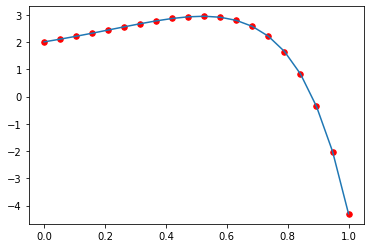

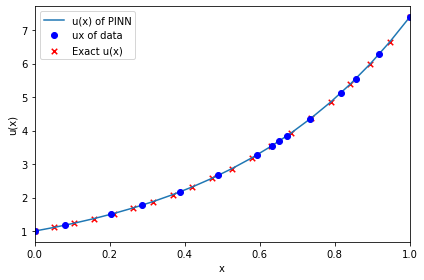

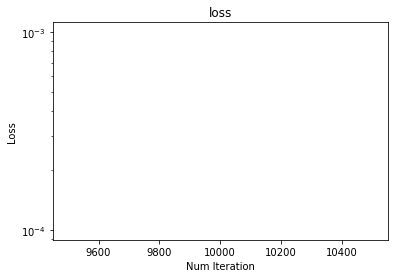

(10001, 0.000109442866)
(10002, 0.00011035741)
(10003, 0.000112140864)
(10004, 0.00011365929)
(10005, 0.000114072565)
(10006, 0.00011321795)
(10007, 0.00011148163)
(10008, 0.000109562374)
(10009, 0.00010811706)
(10010, 0.00010752164)
(10011, 0.00010775378)
(10012, 0.000108498825)
(10013, 0.00010932074)
(10014, 0.00010984593)
(10015, 0.000109867666)
(10016, 0.000109407614)
(10017, 0.00010864738)
(10018, 0.00010782998)
(10019, 0.00010719819)
(10020, 0.00010687096)
(10021, 0.00010684932)
(10022, 0.00010707038)
(10023, 0.00010738557)
(10024, 0.000107666914)
(10025, 0.000107830696)
(10026, 0.00010782425)
(10027, 0.00010768471)
(10028, 0.00010744793)
(10029, 0.000107181026)
(10030, 0.000106926695)
(10031, 0.00010673179)
(10032, 0.000106625426)
(10033, 0.00010659896)
(10034, 0.0001066311)
(10035, 0.00010669672)
(10036, 0.000106769585)
(10037, 0.000106837586)
(10038, 0.000106867294)
(10039, 0.00010686759)
(10040, 0.00010683414)
(10041, 0.00010678218)
(10042, 0.00010671941)
(10043, 0.0001066512

(10361, 0.035823174)
(10362, 0.04055313)
(10363, 0.035773665)
(10364, 0.020436961)
(10365, 0.005372871)
(10366, 0.0010507426)
(10367, 0.007828108)
(10368, 0.01624354)
(10369, 0.016712328)
(10370, 0.009158782)
(10371, 0.0019299528)
(10372, 0.0020618779)
(10373, 0.0070935735)
(10374, 0.009553414)
(10375, 0.0063238745)
(10376, 0.0016674544)
(10377, 0.001019973)
(10378, 0.0039414945)
(10379, 0.005713444)
(10380, 0.0038463725)
(10381, 0.00091007625)
(10382, 0.0004910231)
(10383, 0.0024068397)
(10384, 0.0035715788)
(10385, 0.0023741864)
(10386, 0.0005138574)
(10387, 0.00025939316)
(10388, 0.0014592457)
(10389, 0.0021780063)
(10390, 0.0014584274)
(10391, 0.00035873006)
(10392, 0.00021753277)
(10393, 0.0009141186)
(10394, 0.001306252)
(10395, 0.000870873)
(10396, 0.00025328976)
(10397, 0.00020887789)
(10398, 0.00061799656)
(10399, 0.0008135781)
(10400, 0.0005340674)
(10401, 0.0001758882)
(10402, 0.0001670242)
(10403, 0.00042017802)
(10404, 0.0005398107)
(10405, 0.00037066796)
(10406, 0.0001448

(10722, 0.0020041347)
(10723, 0.0031016173)
(10724, 0.0048229243)
(10725, 0.0073849577)
(10726, 0.011123563)
(10727, 0.01591055)
(10728, 0.021431075)
(10729, 0.025534743)
(10730, 0.026220514)
(10731, 0.020921852)
(10732, 0.01180082)
(10733, 0.0033795913)
(10734, 0.00033059897)
(10735, 0.0030112588)
(10736, 0.007911081)
(10737, 0.010716343)
(10738, 0.009122116)
(10739, 0.0047723567)
(10740, 0.0011491908)
(10741, 0.0007075496)
(10742, 0.0028018518)
(10743, 0.004858386)
(10744, 0.0049136723)
(10745, 0.0030511278)
(10746, 0.0010921736)
(10747, 0.0005416918)
(10748, 0.0013818807)
(10749, 0.0023993498)
(10750, 0.0025108578)
(10751, 0.001707504)
(10752, 0.0007817898)
(10753, 0.00047661184)
(10754, 0.0008084601)
(10755, 0.0012386467)
(10756, 0.0012826667)
(10757, 0.00092553376)
(10758, 0.0005278216)
(10759, 0.00039462763)
(10760, 0.00052354933)
(10761, 0.0006789043)
(10762, 0.0006689379)
(10763, 0.00050810294)
(10764, 0.00034866773)
(10765, 0.00030757097)
(10766, 0.00036245908)
(10767, 0.00040

(11090, 0.00040369912)
(11091, 0.00027237931)
(11092, 0.0001484842)
(11093, 9.756888e-05)
(11094, 0.0001280703)
(11095, 0.00019876566)
(11096, 0.00025408465)
(11097, 0.00025925846)
(11098, 0.00021670238)
(11099, 0.00015554915)
(11100, 0.00011007892)
(11101, 9.881909e-05)
(11102, 0.00011794758)
(11103, 0.00014832054)
(11104, 0.00016895896)
(11105, 0.00016878435)
(11106, 0.0001498996)
(11107, 0.00012395305)
(11108, 0.00010386601)
(11109, 9.71899e-05)
(11110, 0.00010338021)
(11111, 0.000115810806)
(11112, 0.0001262661)
(11113, 0.00012917595)
(11114, 0.00012374995)
(11115, 0.00011332966)
(11116, 0.00010303417)
(11117, 9.6951204e-05)
(11118, 9.6528696e-05)
(11119, 0.000100439545)
(11120, 0.00010572768)
(11121, 0.00010943389)
(11122, 0.00010991105)
(11123, 0.00010728089)
(11124, 0.00010294927)
(11125, 9.879462e-05)
(11126, 9.6250544e-05)
(11127, 9.5835465e-05)
(11128, 9.710366e-05)
(11129, 9.909807e-05)
(11130, 0.000100763005)
(11131, 0.00010143511)
(11132, 0.000100955745)
(11133, 9.9645215e

(11458, 0.00016448562)
(11459, 0.00021033826)
(11460, 0.0002865735)
(11461, 0.00041457155)
(11462, 0.00062839634)
(11463, 0.0009890578)
(11464, 0.0015870561)
(11465, 0.0025826455)
(11466, 0.0041651395)
(11467, 0.006634729)
(11468, 0.010035277)
(11469, 0.01425243)
(11470, 0.017644964)
(11471, 0.018421587)
(11472, 0.014224075)
(11473, 0.007087552)
(11474, 0.0012841183)
(11475, 0.0004723695)
(11476, 0.0038329726)
(11477, 0.0073397034)
(11478, 0.007590265)
(11479, 0.0043349834)
(11480, 0.00094988715)
(11481, 0.00037519913)
(11482, 0.0023209753)
(11483, 0.004088456)
(11484, 0.0036181344)
(11485, 0.0016240133)
(11486, 0.0002740956)
(11487, 0.00069776387)
(11488, 0.0019138545)
(11489, 0.0022850689)
(11490, 0.0014495743)
(11491, 0.00042639428)
(11492, 0.0002775455)
(11493, 0.0008886481)
(11494, 0.0013309879)
(11495, 0.0010655874)
(11496, 0.00044624717)
(11497, 0.00017483272)
(11498, 0.00042764426)
(11499, 0.0007637001)
(11500, 0.0007411357)
(11501, 0.0004027331)
(11502, 0.00014875855)
(11503, 

(11827, 9.12966e-05)
(11828, 9.11436e-05)
(11829, 9.089628e-05)
(11830, 9.0845635e-05)
(11831, 9.09908e-05)
(11832, 9.107488e-05)
(11833, 9.0969006e-05)
(11834, 9.08205e-05)
(11835, 9.0798065e-05)
(11836, 9.088908e-05)
(11837, 9.0929694e-05)
(11838, 9.085912e-05)
(11839, 9.076903e-05)
(11840, 9.075349e-05)
(11841, 9.079824e-05)
(11842, 9.081773e-05)
(11843, 9.078016e-05)
(11844, 9.0716196e-05)
(11845, 9.070396e-05)
(11846, 9.073428e-05)
(11847, 9.074051e-05)
(11848, 9.0722126e-05)
(11849, 9.067894e-05)
(11850, 9.066426e-05)
(11851, 9.0665955e-05)
(11852, 9.0678026e-05)
(11853, 9.066576e-05)
(11854, 9.063505e-05)
(11855, 9.062594e-05)
(11856, 9.061628e-05)
(11857, 9.06199e-05)
(11858, 9.0613474e-05)
(11859, 9.059413e-05)
(11860, 9.057584e-05)
(11861, 9.0570626e-05)
(11862, 9.05714e-05)
(11863, 9.056143e-05)
(11864, 9.05554e-05)
(11865, 9.053679e-05)
(11866, 9.0529174e-05)
(11867, 9.0521826e-05)
(11868, 9.052134e-05)
(11869, 9.051267e-05)
(11870, 9.051054e-05)
(11871, 9.049854e-05)
(1187

(12197, 0.00017624811)
(12198, 0.0015809843)
(12199, 0.0023470018)
(12200, 0.0012198233)
(12201, 0.00013189681)
(12202, 0.0006157563)
(12203, 0.0014791694)
(12204, 0.0011747677)
(12205, 0.0002827742)
(12206, 0.00019588842)
(12207, 0.00080812606)
(12208, 0.0009597889)
(12209, 0.0004281783)
(12210, 9.173226e-05)
(12211, 0.00036497085)
(12212, 0.00066057855)
(12213, 0.0004773766)
(12214, 0.00014179651)
(12215, 0.00015268548)
(12216, 0.00039174093)
(12217, 0.00042174762)
(12218, 0.00020789036)
(12219, 9.103499e-05)
(12220, 0.00020554739)
(12221, 0.0003170034)
(12222, 0.00024062552)
(12223, 0.000108528206)
(12224, 0.00011126448)
(12225, 0.0002050365)
(12226, 0.00022218784)
(12227, 0.00014112538)
(12228, 8.9791436e-05)
(12229, 0.00012862138)
(12230, 0.0001758769)
(12231, 0.00015419007)
(12232, 0.000101360645)
(12233, 9.3225404e-05)
(12234, 0.00012771622)
(12235, 0.0001429945)
(12236, 0.00011683618)
(12237, 9.045877e-05)
(12238, 9.775906e-05)
(12239, 0.000118925)
(12240, 0.00011872177)
(12241

(12566, 8.680358e-05)
(12567, 8.692028e-05)
(12568, 8.7105225e-05)
(12569, 8.7397944e-05)
(12570, 8.786329e-05)
(12571, 8.861076e-05)
(12572, 8.983408e-05)
(12573, 9.182158e-05)
(12574, 9.50761e-05)
(12575, 0.00010042335)
(12576, 0.00010931235)
(12577, 0.00012412875)
(12578, 0.00014901796)
(12579, 0.00019094844)
(12580, 0.00026228957)
(12581, 0.00038369338)
(12582, 0.000592452)
(12583, 0.00094991917)
(12584, 0.0015681464)
(12585, 0.0026214044)
(12586, 0.0044274977)
(12587, 0.0073980317)
(12588, 0.012220775)
(12589, 0.019193787)
(12590, 0.028387144)
(12591, 0.036542546)
(12592, 0.039492596)
(12593, 0.030997247)
(12594, 0.015218912)
(12595, 0.0025176161)
(12596, 0.0017113982)
(12597, 0.009999088)
(12598, 0.016985305)
(12599, 0.015255517)
(12600, 0.006658839)
(12601, 0.00068525295)
(12602, 0.0024559663)
(12603, 0.0078307055)
(12604, 0.009478204)
(12605, 0.005424798)
(12606, 0.000882128)
(12607, 0.00078789546)
(12608, 0.0039939946)
(12609, 0.005666182)
(12610, 0.003654846)
(12611, 0.000730

(12934, 0.022271033)
(12935, 0.025083827)
(12936, 0.023890603)
(12937, 0.017129665)
(12938, 0.008123682)
(12939, 0.0015281901)
(12940, 0.0006017945)
(12941, 0.004304246)
(12942, 0.008720308)
(12943, 0.010222751)
(12944, 0.0076066414)
(12945, 0.0032779009)
(12946, 0.0005456384)
(12947, 0.0009817923)
(12948, 0.0032851116)
(12949, 0.0048986836)
(12950, 0.004393169)
(12951, 0.0023490628)
(12952, 0.0006551324)
(12953, 0.00050563674)
(12954, 0.0015383472)
(12955, 0.0024603033)
(12956, 0.0023480046)
(12957, 0.0014080931)
(12958, 0.00052209897)
(12959, 0.0003634337)
(12960, 0.0008218977)
(12961, 0.0012769998)
(12962, 0.0012545694)
(12963, 0.0008077296)
(12964, 0.000369702)
(12965, 0.00027317778)
(12966, 0.00048317784)
(12967, 0.00070257735)
(12968, 0.0006934425)
(12969, 0.0004761787)
(12970, 0.0002539828)
(12971, 0.00019776111)
(12972, 0.00029823606)
(12973, 0.00041279334)
(12974, 0.0004158216)
(12975, 0.00030569374)
(12976, 0.00018214637)
(12977, 0.00013972903)
(12978, 0.00018766418)
(12979, 

(13302, 9.583483e-05)
(13303, 9.627886e-05)
(13304, 9.692885e-05)
(13305, 9.786146e-05)
(13306, 9.912832e-05)
(13307, 0.00010082842)
(13308, 0.00010306369)
(13309, 0.00010601588)
(13310, 0.00010987604)
(13311, 0.000114937364)
(13312, 0.00012154752)
(13313, 0.00013029971)
(13314, 0.00014184463)
(13315, 0.00015731716)
(13316, 0.00017802519)
(13317, 0.00020614125)
(13318, 0.00024426487)
(13319, 0.00029675284)
(13320, 0.00036882874)
(13321, 0.00046930474)
(13322, 0.0006084991)
(13323, 0.00080439297)
(13324, 0.0010765018)
(13325, 0.0014602286)
(13326, 0.0019884447)
(13327, 0.0027244296)
(13328, 0.0037050333)
(13329, 0.0050148573)
(13330, 0.0066198227)
(13331, 0.008537142)
(13332, 0.010432191)
(13333, 0.012057405)
(13334, 0.012615025)
(13335, 0.011828228)
(13336, 0.009345309)
(13337, 0.005960084)
(13338, 0.0026643802)
(13339, 0.00059744227)
(13340, 0.00019737186)
(13341, 0.0011612093)
(13342, 0.0026980804)
(13343, 0.0039258515)
(13344, 0.004286522)
(13345, 0.0036214313)
(13346, 0.002345534)


(13669, 9.384786e-05)
(13670, 9.668937e-05)
(13671, 0.00010050369)
(13672, 0.000105674706)
(13673, 0.000112690475)
(13674, 0.00012236317)
(13675, 0.0001357048)
(13676, 0.00015433406)
(13677, 0.0001804144)
(13678, 0.000217419)
(13679, 0.00026993337)
(13680, 0.00034551744)
(13681, 0.0004539917)
(13682, 0.0006119832)
(13683, 0.00084027776)
(13684, 0.0011752208)
(13685, 0.0016580798)
(13686, 0.0023638546)
(13687, 0.003360296)
(13688, 0.0047779903)
(13689, 0.00665948)
(13690, 0.00912333)
(13691, 0.011895975)
(13692, 0.014749533)
(13693, 0.016541097)
(13694, 0.01660359)
(13695, 0.013853536)
(13696, 0.009165749)
(13697, 0.0040616742)
(13698, 0.00074532913)
(13699, 0.00021952196)
(13700, 0.0019763554)
(13701, 0.004486992)
(13702, 0.0060727843)
(13703, 0.005886186)
(13704, 0.0040470716)
(13705, 0.001768864)
(13706, 0.00029509372)
(13707, 0.00022795756)
(13708, 0.0012171206)
(13709, 0.002355359)
(13710, 0.0028417408)
(13711, 0.0023855567)
(13712, 0.0013704196)
(13713, 0.00043707367)
(13714, 8.39

(14037, 8.121512e-05)
(14038, 8.1204314e-05)
(14039, 8.11918e-05)
(14040, 8.1176324e-05)
(14041, 8.117937e-05)
(14042, 8.116235e-05)
(14043, 8.116415e-05)
(14044, 8.116023e-05)
(14045, 8.115132e-05)
(14046, 8.115446e-05)
(14047, 8.114955e-05)
(14048, 8.115557e-05)
(14049, 8.116664e-05)
(14050, 8.117578e-05)
(14051, 8.118633e-05)
(14052, 8.121833e-05)
(14053, 8.1252074e-05)
(14054, 8.129965e-05)
(14055, 8.136602e-05)
(14056, 8.147767e-05)
(14057, 8.162393e-05)
(14058, 8.1865655e-05)
(14059, 8.221583e-05)
(14060, 8.2737955e-05)
(14061, 8.352494e-05)
(14062, 8.474031e-05)
(14063, 8.659214e-05)
(14064, 8.944601e-05)
(14065, 9.388946e-05)
(14066, 0.00010084258)
(14067, 0.00011179577)
(14068, 0.00012915683)
(14069, 0.00015694922)
(14070, 0.00020145503)
(14071, 0.00027354655)
(14072, 0.0003900253)
(14073, 0.00058040326)
(14074, 0.00088827277)
(14075, 0.0013913591)
(14076, 0.0021911724)
(14077, 0.0034660744)
(14078, 0.0053649982)
(14079, 0.008114761)
(14080, 0.011447879)
(14081, 0.0149044935)


(14405, 0.00014470468)
(14406, 0.00015052028)
(14407, 0.00013728811)
(14408, 0.00011372661)
(14409, 9.198092e-05)
(14410, 8.102701e-05)
(14411, 8.2882245e-05)
(14412, 9.3136936e-05)
(14413, 0.00010444171)
(14414, 0.00011049479)
(14415, 0.00010885128)
(14416, 0.00010109826)
(14417, 9.132407e-05)
(14418, 8.366843e-05)
(14419, 8.058968e-05)
(14420, 8.208646e-05)
(14421, 8.625052e-05)
(14422, 9.051165e-05)
(14423, 9.280492e-05)
(14424, 9.2328075e-05)
(14425, 8.955291e-05)
(14426, 8.577442e-05)
(14427, 8.244038e-05)
(14428, 8.053347e-05)
(14429, 8.032761e-05)
(14430, 8.1427956e-05)
(14431, 8.307766e-05)
(14432, 8.448839e-05)
(14433, 8.515289e-05)
(14434, 8.489647e-05)
(14435, 8.3931234e-05)
(14436, 8.262196e-05)
(14437, 8.139649e-05)
(14438, 8.057685e-05)
(14439, 8.02643e-05)
(14440, 8.0426355e-05)
(14441, 8.088663e-05)
(14442, 8.141478e-05)
(14443, 8.184442e-05)
(14444, 8.206401e-05)
(14445, 8.200973e-05)
(14446, 8.1773134e-05)
(14447, 8.142647e-05)
(14448, 8.107547e-05)
(14449, 8.08105e-0

(14774, 8.302383e-05)
(14775, 0.000106574276)
(14776, 0.00018709767)
(14777, 0.0002459816)
(14778, 0.00023657849)
(14779, 0.00017290167)
(14780, 0.00010589814)
(14781, 7.973237e-05)
(14782, 0.000100833895)
(14783, 0.00014104001)
(14784, 0.00016466327)
(14785, 0.00015498947)
(14786, 0.00012232551)
(14787, 9.087853e-05)
(14788, 7.95942e-05)
(14789, 9.017036e-05)
(14790, 0.000109447836)
(14791, 0.00012121935)
(14792, 0.00011764297)
(14793, 0.0001026973)
(14794, 8.6988504e-05)
(14795, 7.9652826e-05)
(14796, 8.2774306e-05)
(14797, 9.1499875e-05)
(14798, 9.8552104e-05)
(14799, 9.919468e-05)
(14800, 9.366814e-05)
(14801, 8.592169e-05)
(14802, 8.051955e-05)
(14803, 7.975403e-05)
(14804, 8.2767845e-05)
(14805, 8.67441e-05)
(14806, 8.890505e-05)
(14807, 8.810445e-05)
(14808, 8.5091255e-05)
(14809, 8.174583e-05)
(14810, 7.974793e-05)
(14811, 7.974076e-05)
(14812, 8.1202656e-05)
(14813, 8.2942955e-05)
(14814, 8.388978e-05)
(14815, 8.361867e-05)
(14816, 8.2453975e-05)
(14817, 8.1121674e-05)
(14818,

(15142, 7.871248e-05)
(15143, 7.871024e-05)
(15144, 7.871465e-05)
(15145, 7.8712765e-05)
(15146, 7.872051e-05)
(15147, 7.8718e-05)
(15148, 7.871259e-05)
(15149, 7.872011e-05)
(15150, 7.871647e-05)
(15151, 7.8724195e-05)
(15152, 7.872642e-05)
(15153, 7.8740035e-05)
(15154, 7.8764635e-05)
(15155, 7.8805686e-05)
(15156, 7.8855606e-05)
(15157, 7.892261e-05)
(15158, 7.903386e-05)
(15159, 7.91902e-05)
(15160, 7.942504e-05)
(15161, 7.978603e-05)
(15162, 8.032653e-05)
(15163, 8.1163096e-05)
(15164, 8.2442224e-05)
(15165, 8.441773e-05)
(15166, 8.750326e-05)
(15167, 9.232997e-05)
(15168, 9.993946e-05)
(15169, 0.00011203678)
(15170, 0.00013134706)
(15171, 0.0001624825)
(15172, 0.00021274273)
(15173, 0.00029471898)
(15174, 0.00042799057)
(15175, 0.0006470398)
(15176, 0.0010026946)
(15177, 0.0015854059)
(15178, 0.0025102957)
(15179, 0.003975006)
(15180, 0.0061167115)
(15181, 0.009113553)
(15182, 0.012479165)
(15183, 0.015457686)
(15184, 0.01581766)
(15185, 0.012742831)
(15186, 0.006801566)
(15187, 

(15510, 0.0012365114)
(15511, 0.0019297726)
(15512, 0.003017882)
(15513, 0.004723178)
(15514, 0.0072392845)
(15515, 0.01082998)
(15516, 0.015210141)
(15517, 0.019810125)
(15518, 0.022396853)
(15519, 0.021445679)
(15520, 0.015955301)
(15521, 0.009187611)
(15522, 0.004988839)
(15523, 0.0054484108)
(15524, 0.008712318)
(15525, 0.010422825)
(15526, 0.0081893075)
(15527, 0.0033508968)
(15528, 0.000401569)
(15529, 0.0014913707)
(15530, 0.0045717964)
(15531, 0.0060456498)
(15532, 0.004297616)
(15533, 0.0014765768)
(15534, 0.00045581584)
(15535, 0.001657521)
(15536, 0.0029513584)
(15537, 0.0025479125)
(15538, 0.0010544917)
(15539, 0.00026467134)
(15540, 0.00088303443)
(15541, 0.0018551606)
(15542, 0.0018744932)
(15543, 0.00095976994)
(15544, 0.0001949954)
(15545, 0.0003067261)
(15546, 0.0008728699)
(15547, 0.0010504044)
(15548, 0.0006576211)
(15549, 0.00022897132)
(15550, 0.00024656468)
(15551, 0.000575743)
(15552, 0.00073094125)
(15553, 0.00051141786)
(15554, 0.00018286529)
(15555, 9.7849166e

(15879, 7.926578e-05)
(15880, 8.050893e-05)
(15881, 8.766733e-05)
(15882, 9.438937e-05)
(15883, 9.591479e-05)
(15884, 9.1664726e-05)
(15885, 8.47101e-05)
(15886, 7.921517e-05)
(15887, 7.7670884e-05)
(15888, 7.983562e-05)
(15889, 8.3398816e-05)
(15890, 8.5788895e-05)
(15891, 8.562521e-05)
(15892, 8.3270854e-05)
(15893, 8.0267106e-05)
(15894, 7.8200086e-05)
(15895, 7.7864344e-05)
(15896, 7.8954676e-05)
(15897, 8.050913e-05)
(15898, 8.152919e-05)
(15899, 8.1483406e-05)
(15900, 8.052796e-05)
(15901, 7.9235404e-05)
(15902, 7.822217e-05)
(15903, 7.7866855e-05)
(15904, 7.816127e-05)
(15905, 7.878157e-05)
(15906, 7.9342244e-05)
(15907, 7.956571e-05)
(15908, 7.9373174e-05)
(15909, 7.894209e-05)
(15910, 7.847254e-05)
(15911, 7.820005e-05)
(15912, 7.819653e-05)
(15913, 7.8446625e-05)
(15914, 7.884408e-05)
(15915, 7.92593e-05)
(15916, 7.961285e-05)
(15917, 7.9904275e-05)
(15918, 8.0220925e-05)
(15919, 8.0664366e-05)
(15920, 8.139835e-05)
(15921, 8.2531624e-05)
(15922, 8.4220555e-05)
(15923, 8.6646

(16247, 0.00040443032)
(16248, 0.00041077053)
(16249, 0.00029960342)
(16250, 0.00017368403)
(16251, 0.0001256862)
(16252, 0.0001698342)
(16253, 0.00024598374)
(16254, 0.00028074792)
(16255, 0.00024748407)
(16256, 0.0001761764)
(16257, 0.00012079083)
(16258, 0.00011291004)
(16259, 0.00014310938)
(16260, 0.0001763449)
(16261, 0.00018257524)
(16262, 0.00015837896)
(16263, 0.000123246)
(16264, 0.00010155825)
(16265, 0.000103709535)
(16266, 0.00012175516)
(16267, 0.000138776)
(16268, 0.00014247427)
(16269, 0.00013291494)
(16270, 0.00011985451)
(16271, 0.00011445067)
(16272, 0.00012149076)
(16273, 0.0001378827)
(16274, 0.0001566193)
(16275, 0.00017275817)
(16276, 0.00018689387)
(16277, 0.00020464597)
(16278, 0.00023335515)
(16279, 0.00027931717)
(16280, 0.00034595)
(16281, 0.00043739885)
(16282, 0.00055863376)
(16283, 0.00072318176)
(16284, 0.0009468886)
(16285, 0.0012601227)
(16286, 0.0016893691)
(16287, 0.0022836141)
(16288, 0.0030704287)
(16289, 0.004112352)
(16290, 0.005390168)
(16291, 0

(16616, 0.008047296)
(16617, 0.011663211)
(16618, 0.015456956)
(16619, 0.017125912)
(16620, 0.015144658)
(16621, 0.009046203)
(16622, 0.0027462519)
(16623, 0.00023157163)
(16624, 0.00227744)
(16625, 0.005901832)
(16626, 0.007227457)
(16627, 0.005132186)
(16628, 0.0017299133)
(16629, 0.0003260189)
(16630, 0.0016298138)
(16631, 0.003490893)
(16632, 0.0036340326)
(16633, 0.001929386)
(16634, 0.000377266)
(16635, 0.0004606435)
(16636, 0.0016328627)
(16637, 0.0022687633)
(16638, 0.0015929474)
(16639, 0.00046627215)
(16640, 9.9711266e-05)
(16641, 0.0006675367)
(16642, 0.0012874168)
(16643, 0.001181375)
(16644, 0.0005412606)
(16645, 0.00010818404)
(16646, 0.00026075979)
(16647, 0.0006568283)
(16648, 0.0007569599)
(16649, 0.00047030038)
(16650, 0.00015576798)
(16651, 0.00014037665)
(16652, 0.0003524355)
(16653, 0.00048087933)
(16654, 0.00037067648)
(16655, 0.00016170116)
(16656, 8.30624e-05)
(16657, 0.00018055504)
(16658, 0.0003010616)
(16659, 0.00029663843)
(16660, 0.00018149106)
(16661, 8.72

(16986, 7.6576245e-05)
(16987, 7.668235e-05)
(16988, 7.683884e-05)
(16989, 7.706869e-05)
(16990, 7.74417e-05)
(16991, 7.79898e-05)
(16992, 7.884067e-05)
(16993, 8.016282e-05)
(16994, 8.223692e-05)
(16995, 8.5487074e-05)
(16996, 9.0671514e-05)
(16997, 9.892888e-05)
(16998, 0.00011220717)
(16999, 0.00013367212)
(17000, 0.00016864986)
(17001, 0.00022573558)
(17002, 0.00031982915)
(17003, 0.00047442567)
(17004, 0.00073093286)
(17005, 0.0011513958)
(17006, 0.0018451659)
(17007, 0.0029523245)
(17008, 0.004704912)
(17009, 0.007247294)
(17010, 0.010716138)
(17011, 0.014383737)
(17012, 0.017136812)
(17013, 0.016465778)
(17014, 0.012020967)
(17015, 0.005614287)
(17016, 0.0015306564)
(17017, 0.001850352)
(17018, 0.0049388125)
(17019, 0.0072503327)
(17020, 0.006200577)
(17021, 0.0028761528)
(17022, 0.00036833005)
(17023, 0.0007257075)
(17024, 0.0028611333)
(17025, 0.0041091917)
(17026, 0.0032114738)
(17027, 0.0012321306)
(17028, 0.00027169826)
(17029, 0.0009353567)
(17030, 0.001993503)
(17031, 0.0

(17355, 0.00015848874)
(17356, 0.00013730986)
(17357, 0.00010323894)
(17358, 7.9671874e-05)
(17359, 7.856608e-05)
(17360, 9.444883e-05)
(17361, 0.000111703994)
(17362, 0.00011710459)
(17363, 0.0001080151)
(17364, 9.190287e-05)
(17365, 7.938264e-05)
(17366, 7.676389e-05)
(17367, 8.2878025e-05)
(17368, 9.1360715e-05)
(17369, 9.5761796e-05)
(17370, 9.3467104e-05)
(17371, 8.658477e-05)
(17372, 7.9617595e-05)
(17373, 7.627323e-05)
(17374, 7.740356e-05)
(17375, 8.113427e-05)
(17376, 8.449271e-05)
(17377, 8.5340915e-05)
(17378, 8.342138e-05)
(17379, 8.0114434e-05)
(17380, 7.728777e-05)
(17381, 7.6217155e-05)
(17382, 7.696686e-05)
(17383, 7.8636804e-05)
(17384, 8.0033016e-05)
(17385, 8.0357335e-05)
(17386, 7.954799e-05)
(17387, 7.812646e-05)
(17388, 7.682388e-05)
(17389, 7.618937e-05)
(17390, 7.6324286e-05)
(17391, 7.694947e-05)
(17392, 7.761817e-05)
(17393, 7.794567e-05)
(17394, 7.781517e-05)
(17395, 7.732372e-05)
(17396, 7.672481e-05)
(17397, 7.6281205e-05)
(17398, 7.611604e-05)
(17399, 7.62

(17723, 9.360196e-05)
(17724, 0.00010273854)
(17725, 0.000116897405)
(17726, 0.00013889003)
(17727, 0.00017342411)
(17728, 0.00022775205)
(17729, 0.00031413513)
(17730, 0.00045117323)
(17731, 0.00067093363)
(17732, 0.0010198315)
(17733, 0.0015785217)
(17734, 0.0024501374)
(17735, 0.0038095198)
(17736, 0.005800222)
(17737, 0.008621965)
(17738, 0.012035376)
(17739, 0.015571906)
(17740, 0.01754524)
(17741, 0.016662516)
(17742, 0.012386753)
(17743, 0.0070487997)
(17744, 0.0041241455)
(17745, 0.005402545)
(17746, 0.009648542)
(17747, 0.013106927)
(17748, 0.012785962)
(17749, 0.008244649)
(17750, 0.0036215056)
(17751, 0.0024607894)
(17752, 0.0043306667)
(17753, 0.0057028863)
(17754, 0.0042422633)
(17755, 0.0014551561)
(17756, 0.00032394755)
(17757, 0.0017256587)
(17758, 0.0036267426)
(17759, 0.003763208)
(17760, 0.0022010226)
(17761, 0.00083229796)
(17762, 0.00089035835)
(17763, 0.0016752003)
(17764, 0.0017838819)
(17765, 0.0009816907)
(17766, 0.00024505)
(17767, 0.0003972844)
(17768, 0.0010

(18093, 0.00014567826)
(18094, 0.00011840223)
(18095, 8.927609e-05)
(18096, 7.6146054e-05)
(18097, 8.287631e-05)
(18098, 9.960424e-05)
(18099, 0.00011198232)
(18100, 0.00011153892)
(18101, 9.9771256e-05)
(18102, 8.524687e-05)
(18103, 7.661573e-05)
(18104, 7.724135e-05)
(18105, 8.417023e-05)
(18106, 9.125395e-05)
(18107, 9.359732e-05)
(18108, 9.0149646e-05)
(18109, 8.3589905e-05)
(18110, 7.79327e-05)
(18111, 7.589415e-05)
(18112, 7.75965e-05)
(18113, 8.1020815e-05)
(18114, 8.3621184e-05)
(18115, 8.3833256e-05)
(18116, 8.1772574e-05)
(18117, 7.877362e-05)
(18118, 7.643745e-05)
(18119, 7.571322e-05)
(18120, 7.651251e-05)
(18121, 7.801758e-05)
(18122, 7.92038e-05)
(18123, 7.943755e-05)
(18124, 7.87018e-05)
(18125, 7.7439654e-05)
(18126, 7.631236e-05)
(18127, 7.574745e-05)
(18128, 7.5842974e-05)
(18129, 7.636424e-05)
(18130, 7.694985e-05)
(18131, 7.727177e-05)
(18132, 7.720251e-05)
(18133, 7.6810364e-05)
(18134, 7.628786e-05)
(18135, 7.586181e-05)
(18136, 7.566641e-05)
(18137, 7.5711054e-05

(18461, 7.663937e-05)
(18462, 7.715139e-05)
(18463, 7.790644e-05)
(18464, 7.901859e-05)
(18465, 8.067385e-05)
(18466, 8.31519e-05)
(18467, 8.688926e-05)
(18468, 9.259512e-05)
(18469, 0.00010132901)
(18470, 0.00011480733)
(18471, 0.00013575931)
(18472, 0.00016856514)
(18473, 0.00022018101)
(18474, 0.00030197945)
(18475, 0.0004319797)
(18476, 0.0006399401)
(18477, 0.0009718029)
(18478, 0.0015031014)
(18479, 0.0023417806)
(18480, 0.0036558444)
(18481, 0.005629406)
(18482, 0.008479109)
(18483, 0.01213676)
(18484, 0.01617817)
(18485, 0.019073954)
(18486, 0.019037677)
(18487, 0.014899469)
(18488, 0.008400585)
(18489, 0.003458777)
(18490, 0.0028835102)
(18491, 0.006157648)
(18492, 0.009809867)
(18493, 0.010494368)
(18494, 0.0070097847)
(18495, 0.0025152212)
(18496, 0.0006361532)
(18497, 0.0021414072)
(18498, 0.0044443156)
(18499, 0.00467165)
(18500, 0.0026402662)
(18501, 0.00054614694)
(18502, 0.00041164618)
(18503, 0.001878722)
(18504, 0.0029982927)
(18505, 0.0025387146)
(18506, 0.001133972)

(18830, 7.532627e-05)
(18831, 7.533138e-05)
(18832, 7.533937e-05)
(18833, 7.535025e-05)
(18834, 7.536704e-05)
(18835, 7.538987e-05)
(18836, 7.5414806e-05)
(18837, 7.543685e-05)
(18838, 7.5457516e-05)
(18839, 7.549003e-05)
(18840, 7.552149e-05)
(18841, 7.556076e-05)
(18842, 7.561455e-05)
(18843, 7.568593e-05)
(18844, 7.578615e-05)
(18845, 7.591421e-05)
(18846, 7.6110766e-05)
(18847, 7.636587e-05)
(18848, 7.6736724e-05)
(18849, 7.7275996e-05)
(18850, 7.8046534e-05)
(18851, 7.915818e-05)
(18852, 8.078948e-05)
(18853, 8.319807e-05)
(18854, 8.676431e-05)
(18855, 9.2103386e-05)
(18856, 0.00010014843)
(18857, 0.00011239199)
(18858, 0.00013111398)
(18859, 0.00016001014)
(18860, 0.000204798)
(18861, 0.0002748564)
(18862, 0.00038456006)
(18863, 0.0005578608)
(18864, 0.00083055417)
(18865, 0.0012622944)
(18866, 0.0019368952)
(18867, 0.002988316)
(18868, 0.0045701372)
(18869, 0.006884091)
(18870, 0.009978601)
(18871, 0.013695807)
(18872, 0.017114196)
(18873, 0.018788107)
(18874, 0.017167736)
(1887

(19199, 0.00013597976)
(19200, 0.0001655138)
(19201, 0.00016512578)
(19202, 0.0001381899)
(19203, 0.00010305691)
(19204, 7.958607e-05)
(19205, 7.7009994e-05)
(19206, 9.0927984e-05)
(19207, 0.00010865989)
(19208, 0.000118100885)
(19209, 0.00011437187)
(19210, 0.00010089005)
(19211, 8.5836924e-05)
(19212, 7.6648364e-05)
(19213, 7.625659e-05)
(19214, 8.243222e-05)
(19215, 9.008771e-05)
(19216, 9.44928e-05)
(19217, 9.352509e-05)
(19218, 8.823079e-05)
(19219, 8.1630875e-05)
(19220, 7.678468e-05)
(19221, 7.5309734e-05)
(19222, 7.6929224e-05)
(19223, 8.003485e-05)
(19224, 8.2672406e-05)
(19225, 8.3522966e-05)
(19226, 8.2358696e-05)
(19227, 7.992081e-05)
(19228, 7.735382e-05)
(19229, 7.5634176e-05)
(19230, 7.5196534e-05)
(19231, 7.5871765e-05)
(19232, 7.706658e-05)
(19233, 7.813693e-05)
(19234, 7.860563e-05)
(19235, 7.833718e-05)
(19236, 7.753416e-05)
(19237, 7.654174e-05)
(19238, 7.5718286e-05)
(19239, 7.5284996e-05)
(19240, 7.526488e-05)
(19241, 7.558144e-05)
(19242, 7.601898e-05)
(19243, 7.

(19567, 0.00022508047)
(19568, 0.00029273026)
(19569, 0.00027946307)
(19570, 0.00020263501)
(19571, 0.0001179662)
(19572, 7.637618e-05)
(19573, 9.116115e-05)
(19574, 0.00013735608)
(19575, 0.00017550115)
(19576, 0.00017932705)
(19577, 0.00014985593)
(19578, 0.00010851202)
(19579, 8.020317e-05)
(19580, 7.712885e-05)
(19581, 9.41494e-05)
(19582, 0.00011538736)
(19583, 0.00012582925)
(19584, 0.00012003421)
(19585, 0.00010304886)
(19586, 8.5498556e-05)
(19587, 7.625942e-05)
(19588, 7.793373e-05)
(19589, 8.6663145e-05)
(19590, 9.5618285e-05)
(19591, 9.937501e-05)
(19592, 9.640764e-05)
(19593, 8.9183945e-05)
(19594, 8.194438e-05)
(19595, 7.822708e-05)
(19596, 7.9192054e-05)
(19597, 8.358761e-05)
(19598, 8.895666e-05)
(19599, 9.315281e-05)
(19600, 9.5405565e-05)
(19601, 9.6601296e-05)
(19602, 9.865707e-05)
(19603, 0.00010387575)
(19604, 0.000114120325)
(19605, 0.00013100784)
(19606, 0.00015607617)
(19607, 0.00019212626)
(19608, 0.00024349609)
(19609, 0.00031853563)
(19610, 0.00042852727)
(196

(19934, 0.00020713412)
(19935, 0.00022125122)
(19936, 0.00017880471)
(19937, 0.000118782424)
(19938, 8.520633e-05)
(19939, 9.3619514e-05)
(19940, 0.00012522106)
(19941, 0.00014785343)
(19942, 0.00014277046)
(19943, 0.00011528946)
(19944, 8.662685e-05)
(19945, 7.508301e-05)
(19946, 8.372718e-05)
(19947, 0.000101166006)
(19948, 0.000112389585)
(19949, 0.00010986874)
(19950, 9.694501e-05)
(19951, 8.349644e-05)
(19952, 7.771563e-05)
(19953, 8.100702e-05)
(19954, 8.850499e-05)
(19955, 9.3556424e-05)
(19956, 9.24805e-05)
(19957, 8.635406e-05)
(19958, 7.931317e-05)
(19959, 7.535604e-05)
(19960, 7.5841315e-05)
(19961, 7.91582e-05)
(19962, 8.238661e-05)
(19963, 8.329317e-05)
(19964, 8.153188e-05)
(19965, 7.845651e-05)
(19966, 7.5957505e-05)
(19967, 7.524452e-05)
(19968, 7.625641e-05)
(19969, 7.797804e-05)
(19970, 7.92209e-05)
(19971, 7.93045e-05)
(19972, 7.834912e-05)
(19973, 7.700802e-05)
(19974, 7.603204e-05)
(19975, 7.583376e-05)
(19976, 7.635269e-05)
(19977, 7.7165954e-05)
(19978, 7.7824116

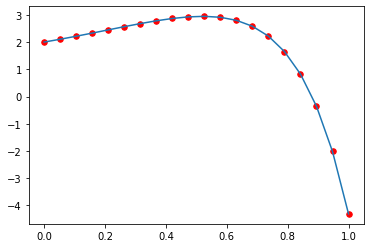

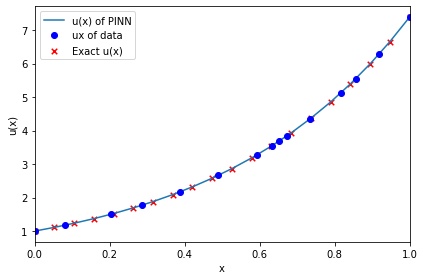

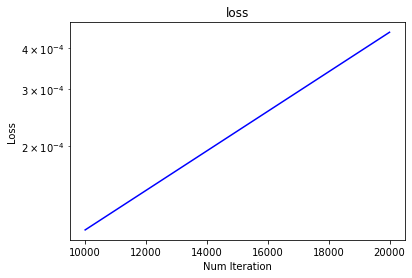

In [2]:
def ElasImag(nIter = 20000, print_period = 1000, plot_period = 1000):
    x_range = np.array([a, b])
    # Network Structure
    layers_U =[1, 30, 30, 30,1]
    layers_V1 =[1, 30, 30, 30,1]
    layers_V2 =[1, 30, 30, 30,1]
    layers_V3 =[1, 30, 30, 30,1]
    layers_V4 =[1, 30, 30, 30,1]
    layers_F =[1, 30, 30, 30,1]
    
    Xx, Ux = import_data('UF.txt')

    f = open("loss_record.txt", "w")


    num_train_tps = 1000
    num_test_tps =20
    model = PhysicsInformedNN(layers_U, layers_V1,layers_V2,layers_V3,layers_V4,layers_F, x_range, f, num_train_tps)

    it_array = []
    loss_array = []
    losses_array = []

    start_time = time.time()
    for it in range(1, nIter+1):
        loss, losses = model.train(Xx, Ux, it, it%print_period==0)
        if (it%print_period==0):
            loss_array.append(loss)
            losses_array.append(losses)
            it_array.append(it)
            dt = time.time() - start_time
            print('Time: ', dt)
            start_time = time.time()
            if (it % plot_period == 0 or it == print_period):
                print("Result Plotted...")
                plt.figure(1)
                x_test, U_test, V1_test, V2_test, V3_test,V4_test, _, _, _, _, _, _, _,_,_,_,F_test = model.test(num_test_tps)
                u_exact = np.exp(2*x_test)
                F_exact = 2*np.exp(2*x_test)-np.exp(x_test**2+2*x_test)+1
                l2Uerror = np.linalg.norm(U_test - u_exact, 2) / np.linalg.norm(u_exact, 2)
                l2Ferror = np.linalg.norm(F_test - F_exact, 2) / np.linalg.norm(F_exact, 2)
                print('L2U error: ', l2Uerror)
                print('L2Ferror: ', l2Ferror)
                xx = Xx[:, 0:1]
                ux = Ux[:, 0:1]
                U = np.hstack((x_test, F_test, F_exact, u_exact,U_test))
                print(U)
                plt.plot(x_test, F_test, label='F_test of PINN')
                plt.scatter(x_test, F_exact, s=30, c='r', marker='o', label='Exact F(x)')
                plt.figure()
                plt.plot(x_test, U_test, label='u(x) of PINN')
                plt.scatter(x_test, u_exact, s=30, c='r', marker='x', label='Exact u(x)')
                plt.plot(xx, ux, c='b', linestyle='' ' ', marker='o', label='ux of data')
                plt.legend(loc='upper left')
                plt.xlabel('x')
                plt.ylabel('u(x)')
                plt.xlim(x_range[0], x_range[1])
                plt.tight_layout()
                plt.show()
                figtopic = 'loss'
                plt.semilogy(it_array, loss_array, '-b')
                plt.xlabel("Num Iteration")
                plt.ylabel("Loss")
                plt.title(figtopic)
                plt.show()
ElasImag(nIter =20000, print_period =10000, plot_period =10000)